# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [80]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\A55964\AppData\Local\Temp\ipykernel_39468\1960795267.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\A55964\AppData\Local\Temp\ipykernel_39468\1960795267.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


**Assessing Data**

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**Identification of data types**

In [7]:
customers.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
PRODUCT_GROUP            object
CUSTOMER_GROUP           object
ONLINE_PURCHASE           int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 369, dtype: object

In [8]:
df_float = customers.select_dtypes('float').columns
df_object = customers.select_dtypes('object').columns
df_int = customers.select_dtypes('int64').columns
df_bool = customers.select_dtypes('bool').columns
df_datetime = customers.select_dtypes('datetime64').columns
print("Floats ="+ str(df_float.shape[0])+ " / Objects ="+str(df_object.shape[0]) +" / Ints ="+str(df_int.shape[0])+" / Bools ="+ str(df_bool.shape[0])+" / Datetimes ="+ str(df_datetime.shape[0]))


Floats =267 / Objects =8 / Ints =94 / Bools =0 / Datetimes =0


In [19]:
df_object

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

**Looking at missing values**

In [39]:
#Looking at Missing values

df_missing = customers.columns[customers.isnull().any()]
df_missing_num = customers[df_missing].isnull().sum()/len(customers)
df_missing_num.sort_values(ascending=True, inplace=True)
df_missing_num

HH_EINKOMMEN_SCORE    0.015486
CJT_TYP_6             0.016765
CJT_TYP_1             0.016765
CJT_KATALOGNUTZER     0.016765
CJT_GESAMTTYP         0.016765
                        ...   
KK_KUNDENTYP          0.584064
ALTER_KIND1           0.938607
ALTER_KIND2           0.973389
ALTER_KIND3           0.993347
ALTER_KIND4           0.998769
Length: 273, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

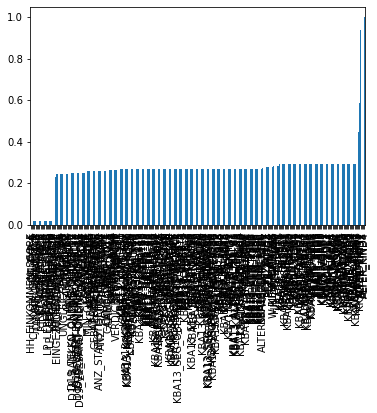

In [18]:
#Plotting the missing values
df_missing_num.plot(kind="bar");
plt.show

In [81]:
# We can clearly see a few attributes being over 40% empty, this won't be properly usable for ML, hence we can remove them
removed_missing = df_missing_num[df_missing_num > 0.4]
print(removed_missing)
customers.drop([col for col in removed_missing.index], axis=1, inplace=True)
customers.shape

EXTSEL992       0.444989
KK_KUNDENTYP    0.584064
ALTER_KIND1     0.938607
ALTER_KIND2     0.973389
ALTER_KIND3     0.993347
ALTER_KIND4     0.998769
dtype: float64


(191652, 363)

In [38]:
# After looking at the documentation, it looks like when the information is unknown the categorical values are either set to 0 or -1
df_unknown = pd.DataFrame()
for col in customers.columns:
    df_unknown[col] = customers[col].isin([-1,0])
df_unknown = df_unknown[df_unknown == True].sum()/len(customers)
df_unknown.sort_values(ascending=True, inplace=True)
df_unknown

C:\Users\A55964\AppData\Local\Temp\ipykernel_39468\2508689526.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_unknown[col] = customers[col].isin([-1,0])
C:\Users\A55964\AppData\Local\Temp\ipykernel_39468\2508689526.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_unknown[col] = customers[col].isin([-1,0])
C:\Users\A55964\AppData\Local\Temp\ipykernel_39468\2508689526.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

LNR                       0.0
KBA13_HALTER_55           0.0
KBA13_HALTER_50           0.0
KBA13_HALTER_45           0.0
KBA13_HALTER_40           0.0
                       ...   
D19_BANKEN_ANZ_12    0.939985
D19_DIGIT_SERV       0.957668
D19_TIERARTIKEL      0.958967
D19_TELKO_ANZ_12      0.96251
D19_BANKEN_LOKAL     0.977537
Length: 369, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

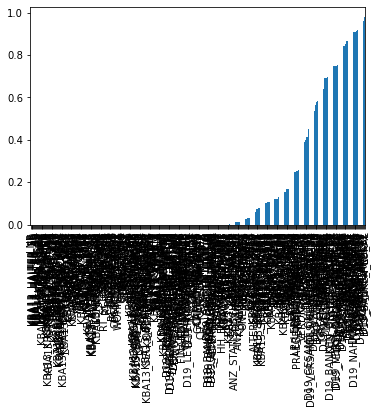

In [82]:
#Plotting the unknown values
df_unknown.plot(kind="bar");
plt.show

In [83]:
# We can clearly see attributes being over 40% empty, this won't be properly usable for ML, hence we can remove them
removed_unknown = df_unknown[df_unknown > 0.4]
print(removed_unknown)
#customers.drop([col for col in removed_missing.index], axis=1, inplace=True)
#customers.shape

KBA13_ANTG4                    0.41208
SHOPPER_TYP                   0.412435
D19_GESAMT_ONLINE_QUOTE_12    0.453316
D19_LOTTO                     0.460632
D19_GESAMT_ANZ_24             0.478586
                                ...   
D19_BANKEN_ANZ_12             0.939985
D19_DIGIT_SERV                0.957668
D19_TIERARTIKEL               0.958967
D19_TELKO_ANZ_12               0.96251
D19_BANKEN_LOKAL              0.977537
Length: 65, dtype: object


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')